In [1]:
# import packages
import numpy as np
import scipy.io as sio
import matplotlib
import matplotlib.pyplot as plt
from numpy.matlib import repmat
from sklearn.preprocessing import normalize
import pandas as pd
import os
from PIL import Image
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

In [2]:
main_folder = 'simpsons_background_removed'  # Replace with your actual path
images = []
labels = []  # To store the group labels (0 to 4, for 5 groups)
original_images = []

# Walk through the subfolders of the main folder
for subdir, _, files in os.walk(main_folder):
    if '.ipynb_checkpoints' in subdir:
        continue
    for file_name in files:
        try:
            img_path = os.path.join(subdir, file_name)
            img = Image.open(img_path).convert('RGB')  
            img_resized = img.resize((200,200))  # Resize image
            images.append(np.array(img_resized).flatten())  # Flatten the image
            original_images.append(np.array(img_resized))  # Store original image for reconstruction
            label = os.path.basename(subdir)  # Use folder name as label
            labels.append(label)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")              


In [3]:
# Convert the list of images and labels into NumPy arrays
images = np.array(images)
labels = np.array(labels)
original_images = np.array(original_images)

def normalize_channels(images):
    n_samples, flattened_size = images.shape 
    side_length = int(np.sqrt(flattened_size // 3))  
    images_reshaped = images.reshape((n_samples, side_length, side_length, 3)) 

    r_channel = images_reshaped[..., 0]
    g_channel = images_reshaped[..., 1]
    b_channel = images_reshaped[..., 2]

    r_channel = r_channel / 255.0
    g_channel = g_channel / 255.0
    b_channel = b_channel / 255.0

    height, width = images_reshaped.shape[1], images_reshaped.shape[2]
    
    return r_channel, g_channel, b_channel, height, width

# You can plot the first two principal components
#plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels, cmap='jet')
#plt.xlabel("Principal Component 1")
#plt.ylabel("Principal Component 2")
#plt.colorbar()  # To show group labels
#plt.show()

# Optionally, you can check how much variance each component explains
#print(pca.explained_variance_ratio_)
#print("Total variance explained:", np.sum(pca.explained_variance_ratio_))

In [4]:
def perform_pca_on_channel(channel_data, n_components):
    n_samples, height, width = channel_data.shape 
    channel_flattened = channel_data.reshape((n_samples, height*width))  
    
    channel_mean = np.mean(channel_flattened, axis=0)
    channel_centered = channel_flattened - channel_mean

    pca = PCA(n_components=n_components)
    Z = pca.fit_transform(channel_centered) 
    principal_components = pca.components_

    return Z, principal_components, channel_mean

In [5]:
def reconstruct_channel(Z, principal_components, channel_mean, height, width):
    reconstructed_flattened = np.dot(Z, principal_components) + channel_mean

    reconstructed_channel = reconstructed_flattened.reshape((-1, height, width))

    return reconstructed_channel


In [6]:
def combine_channels(r, g, b):
    return np.stack((r, g, b), axis=-1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


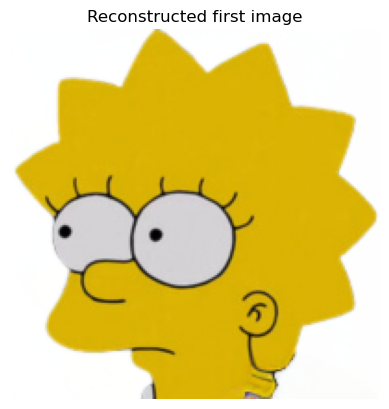

In [7]:
#reconstructed_images = pca.inverse_transform(pca_result)

#reconstructed_images_rescaled = scaler.inverse_transform(reconstructed_images)

# Visualize original and reconstructed images (first few images for comparison)
n_components = 47   # Show the first 5 images for example
r_channel, g_channel, b_channel, height, width = normalize_channels(images)

r_Z, r_principal_components, r_channel_mean = perform_pca_on_channel(r_channel, n_components)
g_Z, g_principal_components, g_channel_mean = perform_pca_on_channel(g_channel, n_components)
b_Z, b_principal_components, b_channel_mean = perform_pca_on_channel(b_channel, n_components)

r_reconstructed = reconstruct_channel(r_Z, r_principal_components, r_channel_mean, height, width)
g_reconstructed = reconstruct_channel(g_Z, g_principal_components, g_channel_mean, height, width)
b_reconstructed = reconstruct_channel(b_Z, b_principal_components, b_channel_mean, height, width)

reconstructed_rgb = combine_channels(r_reconstructed, g_reconstructed, b_reconstructed)

plt.imshow(reconstructed_rgb[0])
plt.title("Reconstructed first image")
plt.axis('off');

In [8]:
X = np.hstack((r_Z, g_Z, b_Z))  # Combine Z from all channels (Red, Green, Blue)
y = labels  # The labels are stored in `labels`

# Encode labels if they are in string format (e.g., folder names)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split data into train and test sets
# Ensure that the split preserves the class distribution
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [9]:
classifier = SVC(kernel='rbf')  # Try different kernels like 'linear', 'rbf', etc.
classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Classification report (precision, recall, F1-score)
print("Classification Report:")
print(classification_report(y_test, y_pred,))

Accuracy: 80.00%
Confusion Matrix:
[[2 0 0 0 0]
 [0 1 1 0 0]
 [0 0 2 0 0]
 [0 0 0 2 0]
 [0 0 1 0 1]]
Classification Report:
              precision    recall  f1-score   support

        bart       1.00      1.00      1.00         2
       homer       1.00      0.50      0.67         2
        lisa       0.50      1.00      0.67         2
       marge       1.00      1.00      1.00         2
         ned       1.00      0.50      0.67         2

    accuracy                           0.80        10
   macro avg       0.90      0.80      0.80        10
weighted avg       0.90      0.80      0.80        10



In [10]:
# Stratified k-fold cross-validation ensures each fold has the same class distribution
strat_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = []

for train_idx, test_idx in strat_kfold.split(X, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    model = SVC(kernel='linear')  # You can experiment with different kernels
    scores = cross_val_score(model, X, y, cv=5)

print("Stratified Cross-validation scores:", scores)
print("Average score:", np.mean(scores))


Stratified Cross-validation scores: [0.9        0.9        1.         1.         0.77777778]
Average score: 0.9155555555555555
